# Michael Bueno

In [384]:
import numpy as np
import math
from sympy import init_printing
init_printing() 
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['axes.linewidth'] = 2


# Constants

In [385]:
G_cgs     = 6.67e-8 # grav constant cgs
G_solar_mass = 4.48e-3    # pc cubed per solar mass per myr squared
k_boltz_cgs   = 1.380649e-16
solar_mass_cgs = 2e33 #grams
cgs_rho_to_solar_pc_rho = 1.48e22 # MULTIPLY cgs density by this to get solar mass pc^-3
cm_to_km = 1e-5 # MULTIPLY cm by this to get km
cm_to_pc = (3.086e18)**-1 # Multiply cm by this to get pc
g_to_sm  = (1.98e33)**-1  # Multiply g by this to get solar masses





# Analytic Functions

## Dehnen Models 

In [386]:
def rho_dehnen(_r,_p0=1,_a=1,_alpha=1,_beta=3):
    #default is NFW
    _term_a = (_r/_a)**_alpha
    _term_b = (1.0 + (_r/_a)) ** (_beta-_alpha)
    _calc = _p0 /(_term_a*_term_b)
    return _calc

def NFW_potential(_r,_p0=1,_a=1,_Grav_constant=1):
    _constants = -4.0*np.pi*_Grav_constant*_p0*(_a**2.0)
    _fraction  = np.log(1.0 + (_r/_a)) / (_r/_a)
    _calc = _constants * _fraction
    return _calc

def HERN_potential(_r,_p0=1,_a=1,_Grav_constant=1):
    _constants = -4.0*np.pi*_Grav_constant*_p0*(_a**2.0)
    _fraction  =  1.0 / (2.0*(1.0 + (_r/_a)))
    _calc = _constants * _fraction
    return _calc
    
            

# Numerical Functions

## Derivatives

In [387]:
# Take derivative of function (an array that is a function of x) W.R.T x
def take_deriv(_x, _y):
    """
    This function takes as input:
    _x = function inputs
    _y = f(function inputs _x)

    Outputs an array with shape (len(_x-1),2);
    containing two arrays: the bin centers for numerical derivative and numerical derivative(_x)
    """
    _dy_dx = np.diff(_y)/np.diff(_x)
    _x2 = (_x[:-1] + _x[1:]) / 2.0
    return np.array((_x2, _dy_dx))

# Poisson Solver for rho of r -> takes phi_of_r to start


def rho_solver_for_phi_of_r_poisson(_r, _phi_func_array, _deriv_func=take_deriv, _Grav_const=1):
    """
    This function calculates numerical rho(r) from the analytic phi of (r) expression by using the
    poisson equation for spherically symmetric potentials

    This function takes as input:
    _r              = radius array
    _phi_func_array = array containing phi(_r)
    _deriv_func     = calls derivative function defined above
    _Grav_constant  = Gravitational constant set equal to 1 as default

    Outputs an array with shape (len(_r),2);
    containing two arrays: the bin centers edges for numerical rho(r) and numerical rho(_r)

    _normalize determines whether or not you want numerical rho to be normalized by the analytic
    expression

    """
    _RHS_constants = (4.0*np.pi*_Grav_const)
    if _Grav_const < 2 and _Grav_const > 0.5 : print("_Grav_const is one")
    # make derivative pieces
    _r, _d_phi_dr = _deriv_func(_x=_r, _y=_phi_func_array)

    # start calcs
    _first_term = (_r**2.0) * _d_phi_dr
    _r, _outer_derive = _deriv_func(_x=_r, _y=_first_term)

    # LHS of Poisson EQ
    _LHS = (_r**-2.0) * _outer_derive
    _calc = _LHS / _RHS_constants
    return np.array((_r, _calc))

# POISSON Rho solver for specified geometry


def rho_of_r_poisson_numerical(_r, _phi_func_array, _rho_func_array, _deriv_func=take_deriv, _normalize=False):
    """
    This function calculates numerical rho(r) from the analytic phi of (r) expression by using the
    poisson equation for spherically symmetric potentials

    This function takes as input:
    _r              = radius array
    _phi_func_array = array containing phi(_r)
    _rho_func_array = array containing rho(_r)
    _deriv_func     = calls derivative function defined above

    Outputs an array with shape (len(_r-2),2);
    containing two arrays: the bin centers for numerical rho(r) and numerical rho(_r)

    _normalize determines whether or not you want numerical rho to be normalized by the analytic
    expression

    """
    _r_output, _calc = rho_solver_for_phi_of_r_poisson(
        _r, _phi_func_array, _deriv_func=_deriv_func)

    if _normalize == True:

        # Normalization Constant
        normalization_constant = _rho_func_array[0] / _calc[0]
#         print (_calc.shape)

        # Normalize and account for infs/nans
        if _r_output.shape[0] < _calc[np.isfinite(_calc)].shape[0]:
            _r_output = _r_output
        else:
            _r_output = _r_output[np.isfinite(_calc)]

        _calc = _calc[np.isfinite(_calc)] * normalization_constant

    return np.array((_r_output, _calc))




## Integrals

In [837]:
def trap_function(_input_array, _function_array, _cumulative_anti=True):
    """
    This function calculates the trapozoidal integral approximation of function_array accross the 
    entire function range

    This function takes as input:
    _input_array    = function inputs
    _function_array = f(function inputs _x) 

    Outputs an array with shape (len(_input_array-1),2);
    containing two arrays: the right bin edges for numerical integral and numerical integral of _function_array
    """
    # number of points
    _N = len(_function_array)
    # def dx
    _a, _b = 0, max(_input_array)
    # holding bins
    integral_result = np.zeros(len(_function_array)-1)
    x_values = np.zeros(len(_function_array)-1)
    # hard code first preset value
    previous_value = 0

    
    if _cumulative_anti == True:
        for ii in range(1, len(_function_array)):
            # get endpoints
            _f = _function_array[ii-1:ii+1]
            # store x value corresponding to right endpoint
            _x = _input_array[ii-1:ii+1]
            # grab the spacing
            _dx = np.diff(_x)
            # def endpoint
            _f_right = _f[1:]  # right endpoint
            _f_left = _f[:-1]  # left endpoint
            # integrate
            integral_result[ii-1] = ((_dx/2.0) *
                                     np.sum(_f_right + _f_left))+previous_value
            # store previous value for summation
            previous_value = integral_result[ii-1]
            # save x values using right bin edge
            x_values[ii-1] = _x[1:]
    if _cumulative_anti == False:
        for ii in range(1, len(_function_array)):
            _f = _function_array[ii-1:ii+1]
            # store x value corresponding to right endpoint
            _x = _input_array[ii-1:ii+1]
            # grab the spacing
            _dx = np.diff(_x)
#             print(_dx)
            # def endpoint
            _f_right = _f[1:]  # right endpoint
            _f_left = _f[:-1]  # left endpoint
            # integrate
            _calc = ((_dx/2.0) * np.sum(_f_right + _f_left))
            if _calc == np.nan:
                raise ValueError("nan in integrater")
            integral_result[ii-1] = _calc  #+previous_value
            # store previous value for summation
            #previous_value = integral_result[ii-1]
            # save x values using right bin edge
            x_values[ii-1] = _x[1:]
        integral_result = np.sum(integral_result)
        x_values = _input_array[-1]

    return np.array((x_values, integral_result))


def phi_solver_of_rho(_r, _analytic_rho, _analytic_phi, _int_function=trap_function, _Grav_const=1,
                      _normalize=True):
    """
    This function calculates the numerical phi(r) by using the poisson equation for spherically
    symmetric potentials

    This function takes as input:
    _r            = radius array
    _analytic_rho = array containing analytic rho(_r)
    _analytic_phi = array containing analytic phi(_r)
    _int_function = trapazoidal integral function defined above
    _Grav_const   = 1

    Outputs an array with shape (len(_r-1),2);
    containing two arrays: the right bin edges for numerical integral and numerical integral of _function_array

    _normalize determines whether or not you want numerical phi to be normalized by the analytic
    expression
    """
    # poisson
    _constants = 4.0*np.pi*_Grav_const
    if _Grav_const < 2 and _Grav_const > 0.5: print("_Grav_const is one")

    # integration stuff

    # get the integral
    _r, _first_term = _int_function(
        _input_array=_r, _function_array=_analytic_rho*_r**2.0)

    # get the second_integral
    _r, _second_term = _int_function(
        _input_array=_r, _function_array=_first_term/(_r**2.0))

    _calc = _second_term *_constants

    if _normalize == True:

        # Normalization Constant
        _normalization_constant = max(_calc)# - max(_analytic_phi)

#         _calc = _calc * _normalization_constant
        _calc = _calc - _normalization_constant

    return np.array((_r, _calc))

# NFW Profile 

In [389]:
_N = 100000
r_array_2_NFW = np.logspace(-1,5,_N) # 0.1 to 1e5

In [390]:
# Rho of r
r_NFW, rho_of_r_analytic_NFW = r_array_2_NFW, rho_dehnen(
    _r=r_array_2_NFW, _p0=1, _a=1, _alpha=1, _beta=3)

#phi of r analytic

phi_of_r_analytic_NFW = NFW_potential(_r=r_array_2_NFW,_p0=1,_a=1,_Grav_constant=1)

# phi of r numerical

_phi_of_r_x_vals_NFW, phi_of_r_numerical_NFW = phi_solver_of_rho(_r=r_array_2_NFW, _analytic_rho=rho_of_r_analytic_NFW,
                                                                 _analytic_phi=phi_of_r_analytic_NFW,
                                                                 _int_function=trap_function, _normalize=True)
#fix phi of r numerical
# adjust = max(phi_of_r_numerical_NFW)-max(phi_of_r_analytic_NFW)

# phi_of_r_numerical_NFW = phi_of_r_numerical_NFW - adjust

# Rho of R numerical
x_val_NFW, numerical_rho_of_r_NFW = rho_of_r_poisson_numerical(
    _r=r_array_2_NFW, _phi_func_array=phi_of_r_analytic_NFW, _rho_func_array=rho_of_r_analytic_NFW,
    _deriv_func=take_deriv, _normalize=True)

# Rho of R numerical from phi_of_r numerical
x_val_NFW_NN, numerical_rho_of_r_NFW_NN = rho_of_r_poisson_numerical(
    _r=_phi_of_r_x_vals_NFW, _phi_func_array=phi_of_r_numerical_NFW, _rho_func_array=rho_of_r_analytic_NFW,
    _deriv_func=take_deriv, _normalize=False)


#circular velocity numerical

_vcirc_of_r_x_vals_NFW, vcirc_of_r_numerical_NFW = take_deriv(_x= _phi_of_r_x_vals_NFW,
                                                              _y=phi_of_r_numerical_NFW)

vcirc_of_r_numerical_NFW = np.sqrt(_vcirc_of_r_x_vals_NFW * np.abs(vcirc_of_r_numerical_NFW))



_Grav_const is one
_Grav_const is one
_Grav_const is one


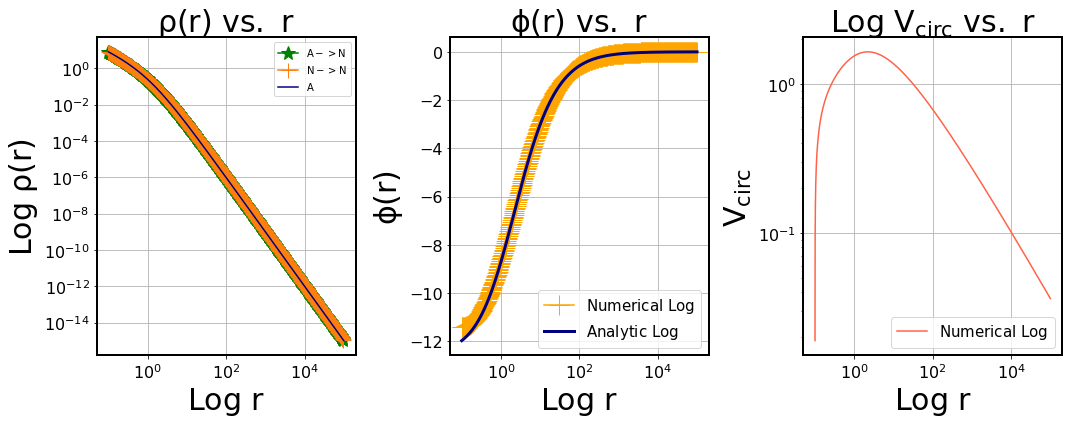

In [391]:
fig = plt.figure(1)
fig.set_figheight(6)
fig.set_figwidth(15)

# create axis object
ax = plt.subplot(131)
plt.grid(True)

# ploting

plt.plot(x_val_NFW, numerical_rho_of_r_NFW,'green',marker="*",markersize=15,markevery=200,
         label=r'$\mathrm{A -> N}$')
plt.plot(x_val_NFW_NN, numerical_rho_of_r_NFW_NN, 'tab:orange',marker="+",markersize=15,
         markevery=200, label=r'$\mathrm{N -> N}$')
plt.plot(r_NFW, rho_of_r_analytic_NFW, 'navy', label=r'$\mathrm{A}$')

# labeling
plt.title(r'$\mathrm{\rho(r)\ vs.\ r}$', size=30)
plt.xlabel(r'$\mathrm{Log\ r}$', size=30)
plt.ylabel(r'$\mathrm{ Log\ \rho(r) }$', size=30)
ax.tick_params(axis='x', which='major', labelsize=16)
ax.tick_params(axis='y', which='major', labelsize=16)
plt.semilogy()
plt.semilogx()
plt.legend(fontsize=10)
plt.tight_layout()

# create axis space
ax = plt.subplot(132)
plt.grid(True)

# ploting
##ploting
plt.plot(_phi_of_r_x_vals_NFW, phi_of_r_numerical_NFW,marker="+",color="orange",markersize=20,markevery=200,label=r'$\mathrm{Numerical\ Log}$')
plt.plot(r_NFW, phi_of_r_analytic_NFW,color='navy',linewidth=3,label=r'$\mathrm{Analytic\ Log}$')

# labeling
plt.title(r'$\mathrm{\phi(r)\ vs.\ r}$', size=30)
plt.xlabel(r'$\mathrm{Log\ r}$', size=30)
plt.ylabel(r'$\mathrm{\phi(r)}$', size=30)
ax.tick_params(axis='x', which='major', labelsize=16)
ax.tick_params(axis='y', which='major', labelsize=16)
# plt.semilogy()
plt.semilogx()
plt.legend(fontsize=15)
plt.tight_layout()

# create axis space
ax = plt.subplot(133)
plt.grid(True)

# ploting
plt.plot(_vcirc_of_r_x_vals_NFW, vcirc_of_r_numerical_NFW, color='tomato',label=r'$\mathrm{Numerical\ Log}$')

# labeling
plt.title(r'$\mathrm{Log\ V_{circ}\ vs.\ r}$', size=30)
plt.xlabel(r'$\mathrm{Log\ r}$', size=30)
plt.ylabel(r'$\mathrm{V_{circ}}$', size=30)
ax.tick_params(axis='x', which='major', labelsize=16)
ax.tick_params(axis='y', which='major', labelsize=16)
plt.semilogx()
plt.semilogy()
plt.legend(fontsize=15)
plt.tight_layout()

# Realistic Galaxy Parameters 

In [392]:
# radius dist
inputs_RC = (np.logspace(18,26,100)) # cm 

#DM Halo
_p0_DM = 8.54e-26 # g cm^-3
_a_DM = 1.23e23  # cm
#stars
_p0_STARS = 7.95e-24  # g cm^-3
_a_STARS = 1.54e22  # cm

## Define Density Distributions 

In [393]:
# DM Halo density distribution
DM_rho_dist_NFW = rho_dehnen(_r=inputs_RC,_p0=_p0_DM,_a=_a_DM,_alpha=1,_beta=3)

# Stars Density distribution
STARS_rho_dist_HERN = rho_dehnen(_r=inputs_RC,_p0=_p0_STARS,_a=_a_STARS,_alpha=1,_beta=4)

# STARS + DM Density distribution
TOT_rho_dist = DM_rho_dist_NFW + STARS_rho_dist_HERN



## Phi, rho, Virc Variables for plotting 

In [394]:
# phi of r analytic
_Grav_constant_cgs = 6.67e-8 # cgs

# DM
phi_of_r_analytic_DM = NFW_potential(_r=inputs_RC*cm_to_pc,_p0=_p0_DM*cgs_rho_to_solar_pc_rho,_a=_a_DM*cm_to_pc,_Grav_constant=G_solar_mass)

# STARS
phi_of_r_analytic_STARS = HERN_potential(_r=inputs_RC,_p0=_p0_STARS,_a=_a_STARS,_Grav_constant=_Grav_constant_cgs)

#PHI of R Numerical
#DM 
_phi_of_r_x_vals_DM, phi_of_r_numerical_DM = phi_solver_of_rho(_r=inputs_RC*cm_to_pc, _analytic_rho=DM_rho_dist_NFW,
                                                                 _analytic_phi=phi_of_r_analytic_DM,
                                                                 _int_function=trap_function, _Grav_const=_Grav_constant_cgs, _normalize=True)
# STARS
#DM 
_phi_of_r_x_vals_STARS, phi_of_r_numerical_STARS = phi_solver_of_rho(_r=inputs_RC, _analytic_rho=STARS_rho_dist_HERN,
                                                                 _analytic_phi=phi_of_r_analytic_STARS,
                                                                _int_function=trap_function, _Grav_const=_Grav_constant_cgs, _normalize=True)



#circular velocity ANALYTIC
# DM
_vcirc_of_r_x_vals_DM_A, _phi_of_r_analytic_dir_DM = take_deriv(_x= inputs_RC,
                                                              _y=phi_of_r_analytic_DM)

vcirc_of_r_analytic_DM = np.sqrt(_vcirc_of_r_x_vals_DM_A * np.abs(_phi_of_r_analytic_dir_DM))

# STARS
_vcirc_of_r_x_vals_STARS_A, _phi_of_r_analytic_dir_STARS = take_deriv(_x= inputs_RC,
                                                              _y=phi_of_r_analytic_STARS)

vcirc_of_r_analytic_STARS = np.sqrt(_vcirc_of_r_x_vals_STARS_A * np.abs(_phi_of_r_analytic_dir_STARS))

# ANALYTIC TOTAL

_vcirc_of_r_x_vals_TOT_A, _phi_of_r_analytic_dir_TOT = take_deriv(_x= inputs_RC,
                                                              _y=phi_of_r_analytic_DM+
                                                                  phi_of_r_analytic_STARS)

vcirc_of_r_analytic_TOT = np.sqrt(_vcirc_of_r_x_vals_DM_A * np.abs(_phi_of_r_analytic_dir_TOT))





#circular velocity numerical
# DM
_vcirc_of_r_x_vals_DM, vcirc_of_r_numerical_DM = take_deriv(_x= _phi_of_r_x_vals_DM,
                                                              _y=phi_of_r_numerical_DM)

vcirc_of_r_numerical_DM = np.sqrt(_vcirc_of_r_x_vals_DM * np.abs(vcirc_of_r_numerical_DM))

# STARS
_vcirc_of_r_x_vals_STARS, vcirc_of_r_numerical_STARS = take_deriv(_x= _phi_of_r_x_vals_STARS,
                                                              _y=phi_of_r_numerical_STARS)

vcirc_of_r_numerical_STARS = np.sqrt(_vcirc_of_r_x_vals_STARS * np.abs(vcirc_of_r_numerical_STARS))

# Numerical TOTAL
_vcirc_of_r_x_vals_TOT_N, _phi_of_r_numerical_dir_TOT = take_deriv(_x= _phi_of_r_x_vals_STARS,
                                                              _y=phi_of_r_numerical_DM+
                                                                  phi_of_r_numerical_STARS)

vcirc_of_r_numerical_TOT = np.sqrt(_vcirc_of_r_x_vals_TOT_N * np.abs(_phi_of_r_numerical_dir_TOT))





## Plot DM, Halo; rho, Psi, and Vcirc


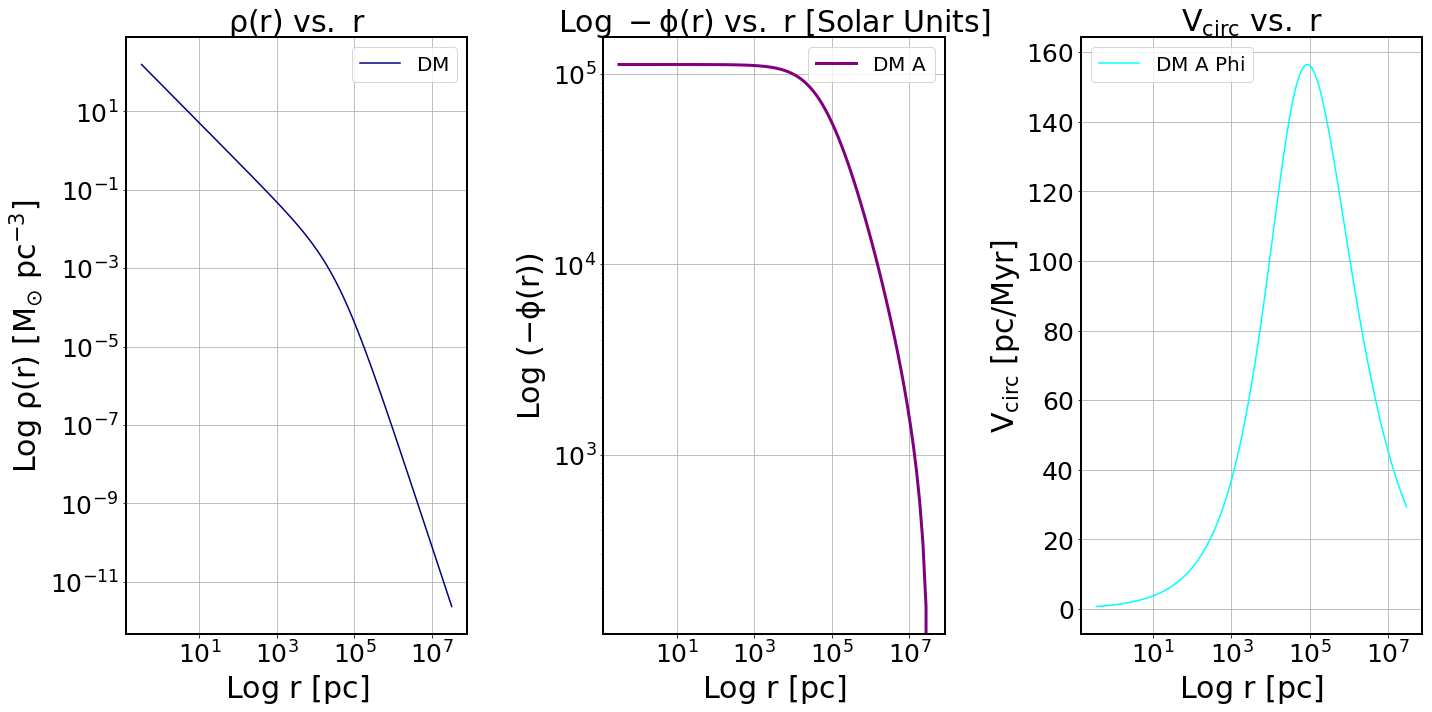

In [395]:
fig = plt.figure(2)
fig.set_figheight(10)
fig.set_figwidth(20)

# create axis object
ax = plt.subplot(131)
plt.grid(True)

# ploting

plt.plot(inputs_RC*cm_to_pc, DM_rho_dist_NFW*cgs_rho_to_solar_pc_rho,'Navy',label=r'$\mathrm{DM}$')
# plt.plot(inputs_RC*cm_to_pc, STARS_rho_dist_HERN*cgs_rho_to_solar_pc_rho, 'tab:orange',label=r'$\mathrm{Stars}$')
# plt.plot(inputs_RC*cm_to_pc, TOT_rho_dist*cgs_rho_to_solar_pc_rho, 'tab:green',marker="*",label=r'$\mathrm{DM\ +\ STARS}$')

# labeling
plt.title(r'$\mathrm{\rho(r)\ vs.\ r}$', size=30)
plt.xlabel(r'$\mathrm{Log\ r\ [pc]}$', size=30)
plt.ylabel(r'$\mathrm{ Log\ \rho(r)\ [M_{\odot}\ pc^{-3}] }$', size=30)
ax.tick_params(axis='x', which='major', labelsize=25)
ax.tick_params(axis='y', which='major', labelsize=25)
plt.semilogy()
plt.semilogx()
plt.legend(fontsize=20)
plt.tight_layout()

# create axis space
ax = plt.subplot(132)
plt.grid(True)

# ploting
# plt.plot(_phi_of_r_x_vals_DM, -phi_of_r_numerical_DM,color="orange",marker="+",markevery=50,markersize=20,label=r'$\mathrm{DM\ N}$')
# plt.plot(_phi_of_r_x_vals_STARS*cm_to_pc, -phi_of_r_numerical_STARS,color='navy',marker="+",markevery=50,markersize=20,linewidth=3,label=r'$\mathrm{STARS\ N}$')
# plt.plot(_phi_of_r_x_vals_STARS*cm_to_pc, -phi_of_r_numerical_STARS + -phi_of_r_numerical_DM,color='maroon',marker="+",markevery=50,markersize=20,linewidth=3,label=r'$\mathrm{STARS\ +\ DM\ N}$')

plt.plot(inputs_RC*cm_to_pc,-phi_of_r_analytic_DM+max(phi_of_r_analytic_DM),color='purple',linewidth=3,label=r'$\mathrm{DM\ A}$')

# plt.plot(inputs_RC*cm_to_pc,-phi_of_r_analytic_STARS,color='green',linewidth=3,label=r'$\mathrm{STARS\ A}$')
# plt.plot(inputs_RC*cm_to_pc,-phi_of_r_analytic_STARS+-phi_of_r_analytic_DM,color='cyan',linewidth=3,label=r'$\mathrm{STARS\ +\ DM\ A}$')
# labeling
plt.title(r'$\mathrm{Log\ -\phi(r)\ vs.\ r\ [Solar\ Units]}$', size=30)
plt.xlabel(r'$\mathrm{Log\ r\ [pc]}$', size=30)
plt.ylabel(r'$\mathrm{Log\ (-\phi(r))}$', size=30)
ax.tick_params(axis='x', which='major', labelsize=25)
ax.tick_params(axis='y', which='major', labelsize=25)
plt.semilogy()
plt.semilogx()
plt.legend(fontsize=20)
plt.tight_layout()


# create axis space
ax = plt.subplot(133)

plt.grid(True)

# ploting

plt.plot(_vcirc_of_r_x_vals_DM_A*cm_to_pc, vcirc_of_r_analytic_DM, color='cyan',label=r'$\mathrm{DM\ A\ Phi}$')
#  plt.plot(_vcirc_of_r_x_vals_STARS_A*cm_to_pc, vcirc_of_r_analytic_STARS*cm_to_km, color='tab:blue',label=r'$\mathrm{STARS\ A\ Phi}$')
# plt.plot(_vcirc_of_r_x_vals_TOT_A*cm_to_pc, vcirc_of_r_analytic_TOT*cm_to_km, color='tab:red',label=r'$\mathrm{DM\ +\ Stars\ A\ Phi}$')
# plt.plot(_vcirc_of_r_x_vals_DM*cm_to_pc, vcirc_of_r_numerical_DM*cm_to_km, color='Navy',marker="+",markevery=50,markersize=20,label=r'$\mathrm{DM\ N\ Phi}$')
# plt.plot(_vcirc_of_r_x_vals_STARS*cm_to_pc, vcirc_of_r_numerical_STARS*cm_to_km, color='tab:orange',marker="+",markevery=50,markersize=20,label=r'$\mathrm{STARS\ N\Phi }$')
# plt.plot(_vcirc_of_r_x_vals_TOT_N*cm_to_pc, vcirc_of_r_numerical_TOT*cm_to_km, color='tab:green',marker="+",markevery=50,markersize=20,label=r'$\mathrm{DM\ +\ Stars\ N\ \Phi}$')

# labeling
plt.title(r'$\mathrm{V_{circ}\ vs.\ r}$', size=30)
plt.xlabel(r'$\mathrm{Log\ r\ [pc]}$', size=30)
plt.ylabel(r'$\mathrm{V_{circ}\ [pc/Myr]}$', size=30)
ax.tick_params(axis='x', which='major', labelsize=25)
ax.tick_params(axis='y', which='major', labelsize=25)

plt.semilogx()
# plt.semilogy()
plt.legend(fontsize=20)

plt.tight_layout()

# f (epsilon) function 

In [855]:
def do_everything(_epsilon_array,_rho_array, _PSI_array):

#         test_dict[value] = value

    # construct integrand array components
    _,_d_rho_d_PSI  = take_deriv(_x=_PSI_array,_y=_rho_array)
    _PSI_bin_WIDTH  = np.diff(_PSI_array)     # bin 
    
    # Check that values arent too close and re increasing
    for aa in _d_rho_d_PSI:
        if aa < 1e-16:
            raise ValueError("Your drho/dPSI values are not changing")
            
    for aa,value in enumerate(np.diff(_d_rho_d_PSI)):
        if value < 0:
            raise ValueError("Your drho/dPSI values are not increasing monotonically")
        
    for bb in _PSI_bin_WIDTH:
        if bb < 1e-16:
            raise ValueError("Your _PSI_bin_WIDTH values are not changing")
            
    for bb,value in enumerate(_PSI_bin_WIDTH):
        if value < 0:
            print (_PSI_bin_WIDTH)
            print ("problem index at",bb)
            raise ValueError("Your _PSI_bin_WIDTH values are not increasing monotonically")

    # calc non square root terms for integrand       
    _non_root_int_term_ = _d_rho_d_PSI * _PSI_bin_WIDTH
    
    # Calc psi bin centers
    _PSI_bin_CENTER = ((_PSI_array[:-1] + _PSI_array[1:]) / 2.0) #take midpoints

    
    # store values before diff wrt to EPS
    _before_int_bin_values = {}

    
    for ii in range(0,_epsilon_array.size):
        


        # construct integrand term; effective where PSI < EPS[ii]
        _calc = np.sqrt(_epsilon_array[ii]-_PSI_bin_CENTER)
        _calc_bools = ~np.isnan(_calc)
        _calc = _calc[_calc_bools]
        _calc = _calc[:np.count_nonzero(_calc)]
        
        # integrand term
        _integrand_term = _calc * _non_root_int_term_[:_calc.size]
        
        #save them
        _before_int_bin_values[ii] = _integrand_term
        
        for jj,value in enumerate(np.diff(_integrand_term)):
            if value < 0: 
                if jj == _integrand_term.size - 2:
                    _integrand_term = _integrand_term[:jj+1]
#                     if jj =< _integrand_term.size-1
                elif jj == _integrand_term.size - 3:
#                     print ("here")
                    _integrand_term = _integrand_term[:jj+1]
#                     print (_integrand_term)
#                     stop
#                     if jj =< _integrand_term.size-1
                elif jj < _integrand_term.size - 3:
                    print ("begin error message in first for loop")
                    print ("int array with error",_integrand_term)
                    print ("sqrt term for this row",_calc)
                    print ("NON sqrt term for this row",_non_root_int_term_[:_calc.size])
                    print ("decreases at this index in the row", jj)
                    print ('happens at this row of the int array',ii)
                    raise ValueError("your integrand array is not increasing monotonically") 
        
        for jj,value in enumerate(np.diff(_integrand_term)):
            if value < 0 and jj <= _epsilon_array.size - 5:
                _integrand_term= _integrand_term[:jj+2]
                
        
    ### iterate and integrate
    
    ## bin for integrated values
    _after_int_bin_values = np.zeros(_epsilon_array.size)
    _after_int_bin_edge_values = np.zeros(_epsilon_array.size)
    
    for keys in _before_int_bin_values.keys():
        
        _integrand_term_sec_loop      = _before_int_bin_values[keys]

#         for ff in range(0,_PSI_array.size-3):
            
        # define PSI limits for integration
        _PSI_limits = _PSI_array[:key+3]
        _PSI_limits = _PSI_limits[-1]

        if _PSI_limits == _PSI_array[-1]:
            break

        #define integrand terms and bin centers for integrating
        _bin_centers_iterate = _PSI_bin_CENTER[_PSI_bin_CENTER < _PSI_limits]
        _integrand_term_sec_loop      = _integrand_term_sec_loop[:_bin_centers_iterate.size]
        _bin_centers_iterate = _bin_centers_iterate[:_integrand_term_sec_loop.size]

        ## debug check
        for jj,value in enumerate(np.diff(_integrand_term_sec_loop)):
            if value < 0:
                if jj == _integrand_term_sec_loop.size - 2:
                    _integrand_term_sec_loop = _integrand_term_sec_loop[:jj+1]
#                     if jj =< _integrand_term.size-1
#                     if jj =< _integrand_term.size-1
                elif jj == _integrand_term.size - 3:
                    _integrand_term_sec_loop = _integrand_term_sec_loop[:jj+1]

                elif jj < _integrand_term_sec_loop.size - 3:
                    print ("begin error message in SECOND for loop")
                    print ("int array with error",_integrand_term_sec_loop)
                    print ("bin centers for this row",_bin_centers_iterate)
                    print ("sqrt term for this row",_calc)
                    print ("NON sqrt term for this row",_non_root_int_term_[:_calc.size])
                    print ("decreases at this index in the row", jj)
                    print ('happens at this row of the int array',key)
                    raise ValueError("your integrand array is not increasing monotonically")
        _bin_centers_iterate = _bin_centers_iterate[:_integrand_term_sec_loop.size]
        for jj,value in enumerate(_integrand_term_sec_loop):
            if value == 0:
                print ("begin error message in SECOND for loop")
                print ("int array with error",_integrand_term_sec_loop)
                print ("bin centers for this row",_bin_centers_iterate)
                print ("sqrt term for this row",_calc)
                print ("NON sqrt term for this row",_non_root_int_term_[:_calc.size])
                print ("decreases at this index in the row", jj)
                print ('happens at this row of the int array',key)
                raise ValueError("you have a 0 in your integrand array ")

        if np.isnan(_integrand_term_sec_loop.sum()) > 0:
            print (np.count_nonzero(_integrand_term_sec_loop))
            print (_integrand_term)
            print ("this many nans",np.isnan(_integrand_term_sec_loop).sum())
            raise ValueError ("you have a nan in the integrand")

        # check array sizes
#             if _integrand_term_sec_loop.size != _bin_centers_iterate.size and key >= _epsilon_array.size-3:
#                 print ("here")
#                 _integrand_term_sec_loop = np.zeros(1)
#                 _bin_centers_iterate = np.zeros(1)

        if _integrand_term_sec_loop.size != _bin_centers_iterate.size and key < _epsilon_array.size-3:
            print ("begin error message")
            print ()
            print (key,"th value")
            print ('int term',_integrand_term_sec_loop)
            print ("bin center term",_bin_centers_iterate)
            print ('int term shape',_integrand_term_sec_loop.size,"bin center shape",_bin_centers_iterate.size)
            raise ValueError("Your bin centers or integrand array are fucked up")

    # integrate

        _bins, _num_integral= trap_function(_input_array=_bin_centers_iterate,
                                 _function_array=_integrand_term_sec_loop,
                                 _cumulative_anti=False)


        #save integrated values
        _after_int_bin_values[keys] = _num_integral
        _after_int_bin_edge_values[keys] = _bins

    ### take derivative
    
#     print (np.diff(_after_int_bin_values),"with size",np.diff(_after_int_bin_values).size)
#     print (np.diff(_epsilon_array),"with size",np.diff(_epsilon_array).size)
#     print (np.diff(_after_int_bin_values)/np.diff(_epsilon_array))
    _bin_centers_final_f_e,_final_f_e = take_deriv(_x=_epsilon_array,_y=_after_int_bin_values)
    
    
        

    return np.array((_bin_centers_final_f_e,_final_f_e, _PSI_bin_CENTER))
  


# test_r_edges,test_int_array = integrate_derived_integrand_array(_bin_centers=_PSI_bin_centers,
#                                                               _integrand_array=_integrand_array_test)



## Testing 

In [856]:
# cgs
def f_E_abel(_r, _epsilon_array,_PSI_values=None):
    
    # define constants
    _constants = 1.0 / ((np.pi**2.0) * np.sqrt(8.0))
    
    
    if _PSI_values == None:
    # define DM and stars potential distributions
        _DM_potential_f = NFW_potential(
            _r=_r*cm_to_pc, _p0=_p0_DM*cgs_rho_to_solar_pc_rho, _a=_a_DM*cm_to_pc, _Grav_constant=G_solar_mass)
    #     _STARS_potential = HERN_potential(
    #         _r=_r, _p0=_p0_STARS, _a=_a_STARS, _Grav_constant=_Grav_constant_cgs)

        # sum potential distributions
        _TOT_Potential = _DM_potential_f# + _STARS_potential
        _phi_constant = max(_TOT_Potential)
    #     print ("the constant is ", _phi_constant)
        # define PSI
        _TOT_PSI = -_TOT_Potential + _phi_constant
        _TOT_PSI = _TOT_PSI[::-1]


    else:
        _TOT_PSI = _epsilon_array
        
    
    
    
    # define phi_0 constant

    
    # Define DM and Star density distributions
    _DM_rho_dist = rho_dehnen(
        _r=_r*cm_to_pc, _p0=_p0_DM*cgs_rho_to_solar_pc_rho, _a=_a_DM*cm_to_pc, _alpha=1, _beta=3)
#     _STARS_rho_dist = rho_dehnen(
#         _r=_r, _p0=_p0_STARS, _a=_a_STARS, _alpha=1, _beta=4)
    
    # sum density distributions
    _TOT_density = _DM_rho_dist #+ _STARS_rho_dist
    _TOT_density = _TOT_density[::-1]
    

#     # take derivative with respect to epsilon
    _bin_centers, _result,_PSI_bin_centers = do_everything(_epsilon_array=_epsilon_array,
                                                           _rho_array=_TOT_density,
                                                           _PSI_array=_TOT_PSI)
    
    
    ## Check for monotonic increase
#     for ii, value in enumerate(np.diff(_result)):
#         if value < 0:
#             print (_result)
#             print (ii)
#             raise ValueError("you have a negative in your AFTER you take a derivative of the integrated result")
    
    return np.array((_bin_centers,_constants*_result,_TOT_PSI,_PSI_bin_centers))



                
                 

In [879]:
inputs_R = (np.logspace(17,26,17))
# epsilons
# inputs_epsilon = (np.linspace(22,26,40))
inputs_epsilon = (np.logspace(3,5,17))

#
# _,int_array_test = f_E_abel(_r=inputs_R, _epsilon_array=inputs_epsilon)
f_e_bin_edges,f_e_array,PSI_TOT_array, PSI_bin_centers = f_E_abel(_r=inputs_R, _epsilon_array=inputs_epsilon,_PSI_values=None)

# f_e_bin_edges2,f_e_array2,PSI_TOT_array2, PSI_bin_centers2 = f_E_abel(_r=inputs_R, _epsilon_array=inputs_epsilon,_PSI_values=True)
# _test_array = f_E_abel(_r=inputs_R, _epsilon_array=inputs_epsilon)







/Users/michael/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in sqrt


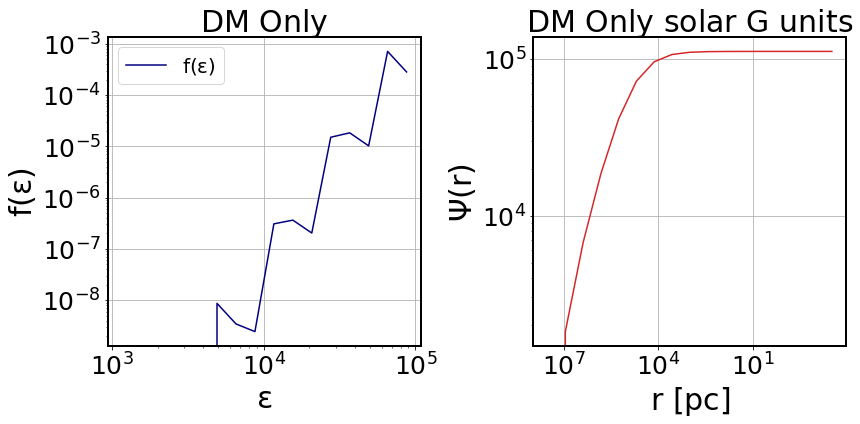

In [880]:
fig = plt.figure(5)
fig.set_figheight(6)
fig.set_figwidth(12)

# create axis object
ax = plt.subplot(121)
plt.grid(True)

# ploting

plt.plot(f_e_bin_edges,f_e_array,'Navy',label=r'$\mathrm{f(\epsilon)}$')
# plt.axvline(f_e_bin_edges[61])
# labeling
plt.title(r'$\mathrm{DM\ Only}$', size=30)
plt.xlabel(r'$\mathrm{\epsilon}$', size=30)
plt.ylabel(r'$\mathrm{f(\epsilon)}$', size=30)
ax.tick_params(axis='x', which='major', labelsize=25)
ax.tick_params(axis='y', which='major', labelsize=25)
# plt.xlim(-1e22,1e23)
plt.semilogy()
plt.semilogx()
plt.legend(fontsize=20)
plt.tight_layout()

ax = plt.subplot(122)
plt.grid(True)

plt.plot(inputs_R[::-1]*cm_to_pc,PSI_TOT_array,'tab:red')
ax = plt.gca()
ax.invert_xaxis()

# plt.axvline(f_e_bin_edges[61])
# labeling
plt.title(r'$\mathrm{DM\ Only\ solar\ G\ units}$', size=30)
plt.xlabel(r'$\mathrm{r\ [pc]}$', size=30)
plt.ylabel(r'$\mathrm{\Psi(r)}$', size=30)
ax.tick_params(axis='x', which='major', labelsize=25)
ax.tick_params(axis='y', which='major', labelsize=25)
# plt.xlim(-1e22,1e23)
plt.semilogy()
plt.semilogx()
# plt.legend(fontsize=20)
plt.tight_layout()




In [147]:
# plt.hist(PSI_bin_centers)
# # plt.xlabel(r'$\mathrm{\Psi\ Values}$', size=30)
# plt.ylabel(r'$\mathrm{Counts}$', size=30)

In [881]:
def do_everything_for_rho(_f_epsilon_array,_f_bin_edges_array, _PSI_bin_CENTER):

#         test_dict[value] = value

    # construct integrand array components
    
    #bin width
    _EPS_bin_WIDTH  = np.diff(_f_bin_edges_array)
    
    # bin center
    _EPS_bin_CENTER = ((_f_bin_edges_array[:-1] + _f_bin_edges_array[1:]) / 2.0)
    
    #bin centers
    _f_EPS_bin_CENTER = ((_f_epsilon_array[:-1] + _f_epsilon_array[1:]) / 2.0) #take midpoints
    
        
    for bb in _EPS_bin_WIDTH:
        if bb < 1e-16:
            raise ValueError("Your _eps_bin_WIDTH values are not changing")
            
    for bb,value in enumerate(_EPS_bin_WIDTH):
        if value < 0:
            print (_EPS_bin_WIDTH)
            print ("problem index at",bb)
            raise ValueError("Your _eps_bin_WIDTH values are not increasing monotonically")


    
    # store values before diff wrt to EPS
    _before_int_bin_values = {}

    
    for ii in range(0,_PSI_bin_CENTER.size):
        


        # construct integrand term; effective where PSI < EPS[ii]
        _calc = np.sqrt(2.0*(_PSI_bin_CENTER[ii]-_EPS_bin_CENTER))
        _calc_bools = ~np.isnan(_calc)
        _calc = _calc[_calc_bools]
        _calc = _calc[:np.count_nonzero(_calc)]
        
        if _calc.size < 1:
            _calc = np.zeros(1)
        
        # integrand term
        _integrand_term = _f_EPS_bin_CENTER[:_calc.size] * _calc
        
        #save them
        _before_int_bin_values[ii] = _integrand_term
        
        for jj,value in enumerate(np.diff(_integrand_term)):
            if value < 0: 
                _integrand_term = _integrand_term[:jj+1]
#                     print (_integrand_term)
#                     stop
#                     if jj =< _integrand_term.size-1

        
#         for jj,value in enumerate(np.diff(_integrand_term)):
#             if value < 0 and jj <= _epsilon_array.size - 5:
#                 _integrand_term= _integrand_term[:jj+2]
                
        
    ### iterate and integrate
    
    ## bin for integrated values
    _after_int_bin_values = np.zeros(_PSI_bin_CENTER.size)
    _after_int_bin_edge_values = np.zeros(_PSI_bin_CENTER.size)
    
    for keys in _before_int_bin_values.keys():
        
        _integrand_term_sec_loop      = _before_int_bin_values[keys] 



        # define PSI limits for integration
        _EPS_limits = _EPS_bin_CENTER[:keys+3]
        _EPS_limits = _EPS_limits[-1]

        if _EPS_limits == _EPS_bin_CENTER[-1]:
            break

    #define integrand terms and bin centers for integrating
        _bin_centers_iterate = _EPS_bin_WIDTH[_EPS_bin_WIDTH < _EPS_limits]
        _integrand_term_sec_loop      = _integrand_term_sec_loop[:_bin_centers_iterate.size]
        _bin_centers_iterate = _bin_centers_iterate[:_integrand_term_sec_loop.size]


#         ## debug check
#         for jj,value in enumerate(np.diff(_integrand_term_sec_loop)):
#             if value < 0:
#                 _integrand_term_sec_loop = _integrand_term_sec_loop[:jj+1]
# #                     if jj =< _integrand_term.size-1
#                     if jj =< _integrand_term.size-1
#                     elif jj == _integrand_term.size - 3:
#                         _integrand_term_sec_loop = _integrand_term_sec_loop[:jj+1]

#                     elif jj < _integrand_term_sec_loop.size - 3:
#                         print ("begin error message in SECOND for loop")
#                         print ("int array with error",_integrand_term_sec_loop)
#                         print ("bin centers for this row",_bin_centers_iterate)
#                         print ("sqrt term for this row",_calc)
#                         print ("decreases at this index in the row", jj)
#                         print ('happens at this row of the int array',key)
#                         raise ValueError("your integrand array is not increasing monotonically")
        _bin_centers_iterate = _bin_centers_iterate[:_integrand_term_sec_loop.size]
#             for jj,value in enumerate(_integrand_term_sec_loop):
#                 if value == 0:
#                     print ("begin error message in SECOND for loop")
#                     print ("int array with error",_integrand_term_sec_loop)
#                     print ("bin centers for this row",_bin_centers_iterate)
#                     print ("sqrt term for this row",_calc)
#                     print ("decreases at this index in the row", jj)
#                     print ('happens at this row of the int array',key)
#                     raise ValueError("you have a 0 in your integrand array ")

        if np.isnan(_integrand_term_sec_loop.sum()) > 0:
            print (np.count_nonzero(_integrand_term_sec_loop))
            print (_integrand_term)
            print ("this many nans",np.isnan(_integrand_term_sec_loop).sum())
            raise ValueError ("you have a nan in the integrand")

        # check array sizes
        #             if _integrand_term_sec_loop.size != _bin_centers_iterate.size and key >= _epsilon_array.size-3:
        #                 print ("here")
        #                 _integrand_term_sec_loop = np.zeros(1)
        #                 _bin_centers_iterate = np.zeros(1)

        if _integrand_term_sec_loop.size != _bin_centers_iterate.size and key < _f_epsilon_array.size-4:
            print ("begin error message")
            print ()
            print (key,"th value")
            print ('int term',_integrand_term_sec_loop)
            print ("bin center term",_bin_centers_iterate)
            print ('int term shape',_integrand_term_sec_loop.size,"bin center shape",_bin_centers_iterate.size)
            raise ValueError("Your bin centers or integrand array are fucked up")

    # integrate
#         print (_bin_centers_iterate,"bins")
#         print (_integrand_term_sec_loop,"int over")
        _bin, _num_integral= trap_function(_input_array=_bin_centers_iterate,
                             _function_array=_integrand_term_sec_loop,
                             _cumulative_anti=False)
#             print (_bin_centers_iterate)
#             print (_integrand_term_sec_loop)


    #save integrated values
            
#         print (_num_integral)
#         print (_bin)
        _after_int_bin_values[keys] = _num_integral
        _after_int_bin_edge_values[keys] = _bin

    ### take derivative
    
#     print (np.diff(_after_int_bin_values),"with size",np.diff(_after_int_bin_values).size)
#     print (np.diff(_epsilon_array),"with size",np.diff(_epsilon_array).size)
#     print (np.diff(_after_int_bin_values)/np.diff(_epsilon_array))
    
        

    return np.array((_after_int_bin_edge_values,_after_int_bin_values*4.0*np.pi))



In [882]:


rho_r_bin_edges,rho_r_array = do_everything_for_rho(_f_epsilon_array=f_e_array,
                                                    _f_bin_edges_array=f_e_bin_edges,
                                                    _PSI_bin_CENTER=PSI_bin_centers)



# DM Halo density distribution
DM_rho_dist_NFW_recover = rho_dehnen(_r=inputs_R,_p0=_p0_DM,_a=_a_DM,_alpha=1,_beta=3)


/Users/michael/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in sqrt


In [883]:
print (rho_r_array)

[0.00000000e+00 0.00000000e+00 5.85622873e-02 1.57377558e+00
 2.46929193e+01 1.49763854e+02 3.86485050e+02 3.52551275e+03
 1.21684992e+04 1.22571121e+04 1.22815812e+04 1.22882973e+04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]


In [873]:
# shift = rho_r_array.size-np.count_nonzero(rho_r_array)
# rho_r_array[shift:rho_r_bin_edges.size].size,rho_r_bin_edges[shift:].size

In [888]:
_r_bin_centers = (inputs_R[1:] + inputs_R[:-1])/2

# plt.plot(rho_r_bin_edges[:np.count_nonzero(rho_r_array)],rho_r_array[:np.count_nonzero(rho_r_array)])
recovery_r_edges,recovery_r_vals = rho_r_bin_edges[rho_r_array > 0],rho_r_array[rho_r_array > 0]
recovery_r_edges,recovery_r_vals = recovery_r_edges[::-1],recovery_r_vals



_vcirc_of_r_x_vals_DM, vcirc_of_r_numerical_DM = take_deriv(_x= np.diff(inputs_R),
                                                              _y=PSI_bin_centers)

vcirc_of_r_numerical_DM = np.sqrt(_vcirc_of_r_x_vals_DM * np.abs(vcirc_of_r_numerical_DM))


_phi_of_r_x_vals_DM, phi_of_r_numerical_DM = phi_solver_of_rho(_r=recovery_r_edges, _analytic_rho=recovery_r_vals,
                                                                 _analytic_phi=PSI_bin_centers[shift:rho_r_bin_edges.size],
                                                                 _int_function=trap_function, _Grav_const=G_solar_mass,
                                                               _normalize=True)


# DM
_vcirc_of_r_x_vals_DM_num, vcirc_of_r_numerical_DM_num = take_deriv(_x= _phi_of_r_x_vals_DM[::-1],
                                                              _y=phi_of_r_numerical_DM)

vcirc_of_r_numerical_DM_num = np.sqrt(_vcirc_of_r_x_vals_DM_num * np.abs(vcirc_of_r_numerical_DM_num))




/Users/michael/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


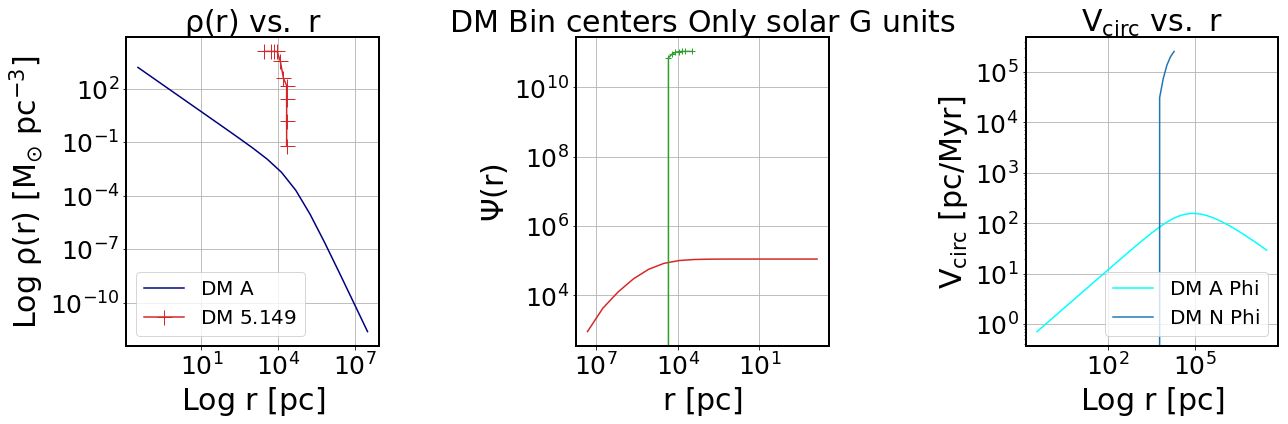

In [889]:
fig = plt.figure(3)
fig.set_figheight(6)
fig.set_figwidth(18)

# create axis object
ax = plt.subplot(131)
plt.grid(True)

# ploting

plt.plot(inputs_R*cm_to_pc, DM_rho_dist_NFW_recover*cgs_rho_to_solar_pc_rho,'Navy',label=r'$\mathrm{DM\ A}$')
plt.plot(recovery_r_edges,recovery_r_vals,'tab:red',marker="+",markersize=15,
         label=r'$\mathrm{DM\ 5.149}$')


# labeling
plt.title(r'$\mathrm{\rho(r)\ vs.\ r}$', size=30)
plt.xlabel(r'$\mathrm{Log\ r\ [pc]}$', size=30)
plt.ylabel(r'$\mathrm{ Log\ \rho(r)\ [M_{\odot}\ pc^{-3}] }$', size=30)
ax.tick_params(axis='x', which='major', labelsize=25)
ax.tick_params(axis='y', which='major', labelsize=25)
plt.semilogy()
plt.semilogx()
plt.legend(fontsize=20)
plt.tight_layout()



ax = plt.subplot(132)
plt.grid(True)

plt.plot(_r_bin_centers[::-1]*cm_to_pc,PSI_bin_centers,'tab:red',label=r'$\mathrm{bin\ centers}$')
# plt.plot(_r_bin_centers[shift:rho_r_bin_edges.size]*cm_to_pc,PSI_bin_centers[shift:rho_r_bin_edges.size],'tab:blue')
plt.plot(_phi_of_r_x_vals_DM[::-1], -phi_of_r_numerical_DM,'tab:green',marker='+',label=r'$\mathrm{from rho_r}$')
ax = plt.gca()
ax.invert_xaxis()

# plt.axvline(f_e_bin_edges[61])
# labeling
plt.title(r'$\mathrm{DM\ Bin\ centers\ Only\ solar\ G\ units}$', size=30)
plt.xlabel(r'$\mathrm{r\ [pc]}$', size=30)
plt.ylabel(r'$\mathrm{\Psi(r)}$', size=30)
ax.tick_params(axis='x', which='major', labelsize=25)
ax.tick_params(axis='y', which='major', labelsize=25)
# plt.xlim(-1e22,1e23)
plt.semilogy()
plt.semilogx()
# plt.legend(fontsize=20)
plt.tight_layout()




ax = plt.subplot(133)

plt.grid(True)

# ploting

plt.plot(_vcirc_of_r_x_vals_DM_A*cm_to_pc, vcirc_of_r_analytic_DM, color='cyan',label=r'$\mathrm{DM\ A\ Phi}$')
plt.plot(_vcirc_of_r_x_vals_DM_num, vcirc_of_r_numerical_DM_num, color='tab:blue',label=r'$\mathrm{DM\ N\ Phi}$')
plt.title(r'$\mathrm{V_{circ}\ vs.\ r}$', size=30)
plt.xlabel(r'$\mathrm{Log\ r\ [pc]}$', size=30)
plt.ylabel(r'$\mathrm{V_{circ}\ [pc/Myr]}$', size=30)
ax.tick_params(axis='x', which='major', labelsize=25)
ax.tick_params(axis='y', which='major', labelsize=25)

plt.semilogx()
plt.semilogy()
plt.legend(fontsize=20)

plt.tight_layout()